# CLUSTERING THE GENRES
This notebook is created for reducing the size of the data set.
get_artist_info.py brought the responses from the API. And get_genres.py created almost 500 hundred extra dimensions
Here I will run Principal component analysis to reduce the dimensions to 2 and then use K-means to cluster the data.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# principal component analysis
from sklearn.decomposition import PCA
# elbow method
from sklearn.cluster import KMeans
# silhouette score
from sklearn.metrics import silhouette_score
# hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage


I don't want to perform this dimensionality reduction on the cloud as it's not necessary for the scope of this project. Rather, PCA + K-Means will be appied locally and the resulting cluster column will be added to sparkify mini dataset. The rationale for this decision is, spark would be an overkill for this task.

In [3]:
# read mini_sparkify_event_data.json from data folder
df = pd.read_json('../data/mini_sparkify_event_data.json', lines=True)
# read genres.csv from data folder
genres = pd.read_csv('../data/genres.csv')


In [4]:
# change column name to artist on genres dataframe
genres.rename(columns={'name':'artist'}, inplace=True)

In [5]:
# lowercase df['artist'] column
df['artist'] = df['artist'].str.lower()

In [6]:
# join the two dataframes on artist column
merged = df.merge(genres, on='artist', how='left')

Musicbrainz API returned genres for about %20 percent of the artists. When the merge is done,
the missing values are filled with NaN. Dropping them would cause us to lose a lot of data.
So, I decided to fill the missing values with the values with 0. However, I don't want to fill 
the other columns with 0. So, I will fill the missing values with 0 only for the genre columns.

In [7]:
# mark columns to be filled with 0
fill_cols = merged.columns[20:]


In [8]:
# fill the missing values with 0
processed_df = merged[fill_cols].fillna(0).copy()

In [9]:
processed_df.head()

,2008 universal fire victim,2013,4ad,a cappella,acid jazz,acoustic rock,actor,affiance,afrobeat,aggro berlin,...,zombiecore,zydeco,Choir,Group,Orchestra,Other,Person,female,male,other
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Okay, everything looks good. Now, just to tame my curiousity, I will check which genres and types(gender or band) are the mostly populated in our df

In [10]:
# exclude first 20 elements from the column names
processed_df.astype(bool).sum(axis=0).sort_values(ascending=False).head(10)


Group               45667
male                11564
indie rock           6079
rock                 5722
female               5385
hip hop              3594
pop                  3451
country              1996
alternative rock     1794
blues rock           1717
dtype: int64

In [11]:
# principal component analysis
from sklearn.decomposition import PCA

In [12]:
pca_df = processed_df.copy()

In [13]:
# instantiate PCA
pca = PCA(n_components=2)
# fit and transform pca_df
pca_df = pca.fit_transform(pca_df)


In [14]:
# create a dataframe from pca_df
pca_df = pd.DataFrame(pca_df, columns=['pc1', 'pc2'])

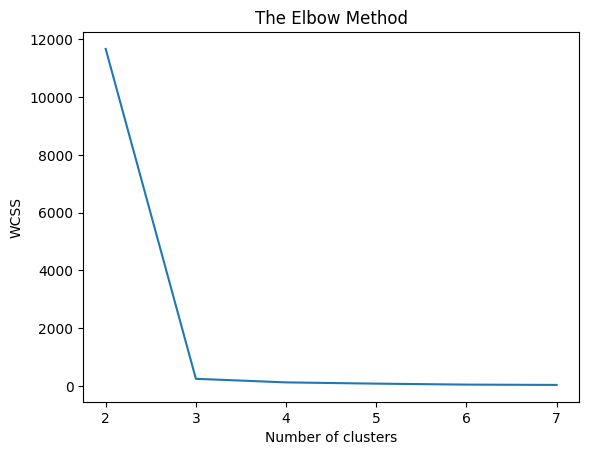

In [15]:
# cluster the data
from sklearn.cluster import KMeans

# use elbow method to find the optimal number of clusters
wcss = []
for i in range(2, 8):
    kmeans = KMeans(n_clusters=i, init='k-means++',
    n_init =10,  random_state=42)
    kmeans.fit(pca_df)
    wcss.append(kmeans.inertia_)

# plot the elbow method
plt.plot(range(2, 8), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()



Okay, Clearly the elbow occurs at 3 clusters. Easy catch!

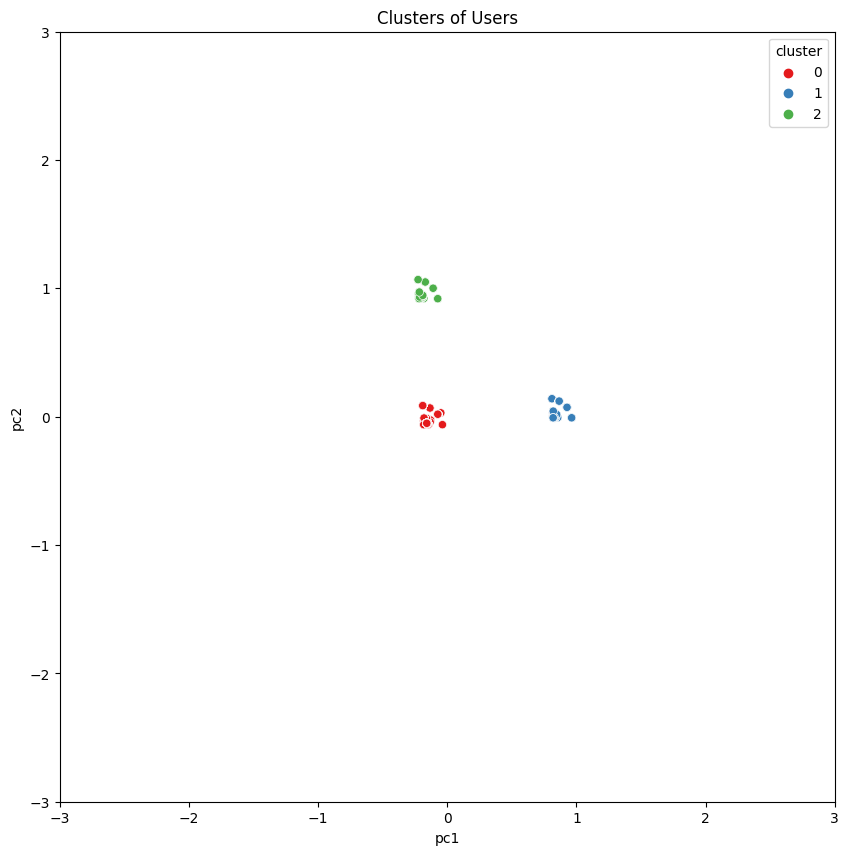

In [16]:
# initialize kmeans with 3 clusters
kmeans = KMeans(n_clusters=3, init='k-means++',
n_init=10, random_state=42)

# fit and predict pca_df
y_kmeans = kmeans.fit_predict(pca_df)

# create a dataframe from pca_df
pca_df = pd.DataFrame(pca_df, columns=['pc1', 'pc2'])

# add cluster column to pca_df
pca_df['cluster'] = y_kmeans

# plot the clusters
plt.figure(figsize=(10, 10))
sns.scatterplot(x='pc1', y='pc2', hue='cluster', data=pca_df, palette='Set1')
# set the scale of axes properly
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.title('Clusters of Users')
plt.show()

In [17]:
pca_df.cluster.value_counts()

0    231173
1     45667
2     11564
Name: cluster, dtype: int64

In [18]:
# add clusters back to merged dataframe
merged['cluster'] = y_kmeans

In [19]:
# check the most important features for each cluster
for i in range(3):
    print('Cluster {}'.format(i))
    # sort the values in descending order and show top 10 after excluding first 20 columns
    print(merged[merged['cluster'] == i].astype(bool).sum(axis=0).sort_values(ascending=False).head(30).index[20:])

Cluster 0
Index(['pop', 'industrial rock', 'soul', 'rock', 'country', 'jazz',
       'anti-folk', 'folk rock', 'folk', 'swedish'],
      dtype='object')
Cluster 1
Index(['userAgent', 'itemInSession', 'indie rock', 'rock', 'hip hop',
       'alternative rock', 'blues rock', 'uk', 'electronic', 'nu metal'],
      dtype='object')
Cluster 2
Index(['userAgent', 'itemInSession', 'country', 'hip hop', 'pop', 'rock',
       'folk rock', 'soul', 'jazz', 'blues rock'],
      dtype='object')


Okay, now it's the decisive point. I want to check whether my clusters have something to do with churn behaviour

In [20]:
# define churn column
merged['churn'] = merged['page'].apply(lambda x: 1 if x == 'Cancellation Confirmation' else 0)

In [21]:
merged["churn"].value_counts()

0    288352
1        52
Name: churn, dtype: int64

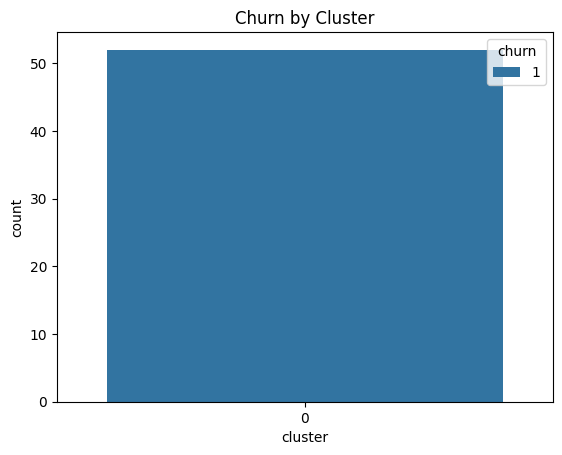

In [22]:
# plot churn and cluster
sns.countplot(x='cluster', hue='churn', data=merged[merged['churn'] != 0])
plt.title('Churn by Cluster')
plt.show()


Seems like all of the churners are clustered within cluster 0. And since we didn't use any other information than genre and artist types, I am pretty sure that there's no data leakage

In [23]:
# tabulate the churn by cluster
pd.crosstab(merged['cluster'], merged['churn'])

churn,0,1
cluster,,
0,231121,52
1,45667,0
2,11564,0


I am extremely happy with this result.

In [24]:
merged["ext:score"].mean()

79.67091736330862

In [25]:
# ext:score variable seems important for churn. Calculate mean for each cluster
for i in range(3):
    print('Cluster {}'.format(i))
    print(merged[merged['cluster'] == i]["ext:score"].mean())

Cluster 0
77.60607506361323
Cluster 1
80.34839161757944
Cluster 2
78.11829816672432


In [26]:
# rename gender_x column 
merged.rename(columns={'gender_x':'gender'}, inplace=True)

In [27]:
final_cols =  df.columns
# add cluster and churn columns to final_cols
final_cols = final_cols.append(pd.Index(['cluster', 'churn']))
final_cols

Index(['ts', 'userId', 'sessionId', 'page', 'auth', 'method', 'status',
       'level', 'itemInSession', 'location', 'userAgent', 'lastName',
       'firstName', 'registration', 'gender', 'artist', 'song', 'length',
       'cluster', 'churn'],
      dtype='object')

In [28]:
# create a dataframe with final_cols
final_df = merged[final_cols].copy()
# save the final dataframe to json file
final_df.to_json('../data/final_df.json', orient='records', lines=True)


Even though I didn't use any other information than genre and artist types, I was able to cluster the data and see that the churners are clustered within cluster 0. This is a very good result.

I will save the cluster column to the mini dataset and use it in the next notebook where I will first perform exploratory data analysis, feature engineering and then build a model to predict churn.

